# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-20 07:01:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [              <=>   ] 201.24M  55.0MB/s    in 3.9s    

2024-10-20 07:01:16 (51.1 MB/s) - ‘data.txt.zip’ saved [211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [7]:
set_random_seed(42)

In [13]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)

y_pred_ridge = ridge_model.predict(X_test_scaled)

rmse_for_model = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"RMSE for Ridge Regression: {rmse_for_model}")


RMSE for Ridge Regression: 9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [14]:
y_mean = np.mean(y_train)

y_pred_mean = np.full_like(y_test, y_mean)

best_rmse_metric = np.sqrt(mean_squared_error(y_test, y_pred_mean))
print(f"RMSE for constant prediction (mean): {best_rmse_metric}")


RMSE for constant prediction (mean): 10.863228020678134


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [15]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

input_dim = X_train_scaled.shape[1]
model = LinearRegressionModel(input_dim).to(device)


In [16]:
def mse_loss(predictions, targets):
    return ((predictions - targets) ** 2).mean()

def manual_sgd_step(model, learning_rate):
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad


In [17]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

learning_rate = 0.001
epochs = 10
batch_size = 10000

train_losses = []
test_losses = []
train_rmse = []
test_rmse = []

for epoch in range(epochs):
    # Перемешиваем индексы для стохастического градиентного спуска
    permutation = torch.randperm(X_train_tensor.size(0))

    # Проходим по мини-батчам
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        X_batch = X_train_tensor[indices]
        y_batch = y_train_tensor[indices]

        predictions = model(X_batch)

        loss = mse_loss(predictions, y_batch)

        loss.backward()

        manual_sgd_step(model, learning_rate)

        model.zero_grad()

    # После каждой эпохи проверяем на обучающей и тестовой выборке
    with torch.no_grad():
        train_predictions = model(X_train_tensor)
        train_loss = mse_loss(train_predictions, y_train_tensor).item()
        train_rmse_value = torch.sqrt(mse_loss(train_predictions, y_train_tensor)).item()

        test_predictions = model(X_test_tensor)
        test_loss = mse_loss(test_predictions, y_test_tensor).item()
        test_rmse_value = torch.sqrt(mse_loss(test_predictions, y_test_tensor)).item()

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_rmse.append(train_rmse_value)
        test_rmse.append(test_rmse_value)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {train_loss}, Test Loss = {test_loss}, Train RMSE = {train_rmse_value}, Test RMSE = {test_rmse_value}")


Epoch 1/10: Train Loss = 3308525.0, Test Loss = 3308789.25, Train RMSE = 1818.9351806640625, Test RMSE = 1819.0078125
Epoch 2/10: Train Loss = 2740985.75, Test Loss = 2741198.75, Train RMSE = 1655.59228515625, Test RMSE = 1655.6566162109375
Epoch 3/10: Train Loss = 2270805.5, Test Loss = 2271027.75, Train RMSE = 1506.919189453125, Test RMSE = 1506.992919921875
Epoch 4/10: Train Loss = 1881282.0, Test Loss = 1881478.875, Train RMSE = 1371.598388671875, Test RMSE = 1371.6700439453125
Epoch 5/10: Train Loss = 1558578.875, Test Loss = 1558741.125, Train RMSE = 1248.4305419921875, Test RMSE = 1248.49560546875
Epoch 6/10: Train Loss = 1291233.625, Test Loss = 1291378.125, Train RMSE = 1136.3245849609375, Test RMSE = 1136.38818359375
Epoch 7/10: Train Loss = 1069749.25, Test Loss = 1069872.875, Train RMSE = 1034.286865234375, Test RMSE = 1034.3465576171875
Epoch 8/10: Train Loss = 886258.375, Test Loss = 886388.1875, Train RMSE = 941.4129638671875, Test RMSE = 941.48193359375
Epoch 9/10: Trai

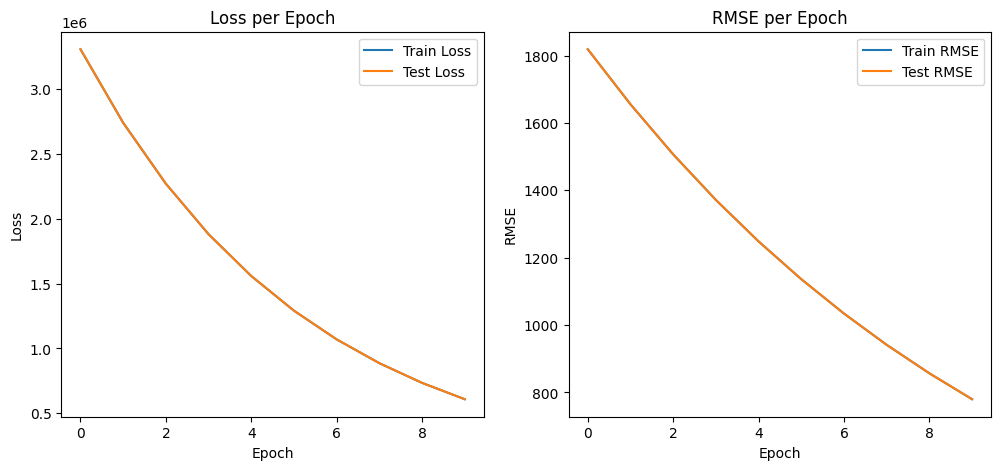

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_rmse, label='Train RMSE')
plt.plot(range(epochs), test_rmse, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE per Epoch')
plt.legend()

plt.show()


## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

## попытка номер 1

In [19]:
from torch.utils.data import Dataset, DataLoader

class MusicDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

train_dataset = MusicDataset(X_train_scaled, y_train)
test_dataset = MusicDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)


In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

model = NeuralNetwork(input_dim=X_train_scaled.shape[1]).to(device)


In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()


In [22]:
def train(model, optimizer, criterion, train_loader, test_loader, epochs=10):
    train_losses = []
    test_losses = []
    test_rmses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch.view(-1, 1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        test_loss, test_rmse = test(model, criterion, test_loader)
        test_losses.append(test_loss)
        test_rmses.append(test_rmse)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

    return train_losses, test_losses, test_rmses


In [23]:
def test(model, criterion, test_loader):
    model.eval()
    test_loss = 0
    all_predictions = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch.view(-1, 1))
            test_loss += loss.item()
            all_predictions.append(predictions.cpu().numpy())

    test_loss /= len(test_loader)
    all_predictions = np.concatenate(all_predictions)
    rmse = np.sqrt(mean_squared_error(y_test, all_predictions))

    return test_loss, rmse


In [24]:
train_losses, test_losses, test_rmses = train(model, optimizer, criterion, train_loader, test_loader, epochs=50)


Epoch 1/50, Train Loss: 1144328.4864, Test Loss: 190571.3845, Test RMSE: 436.4211
Epoch 2/50, Train Loss: 120656.1008, Test Loss: 75131.1137, Test RMSE: 273.7092
Epoch 3/50, Train Loss: 34374.5947, Test Loss: 8168.8364, Test RMSE: 90.2195
Epoch 4/50, Train Loss: 3209.8990, Test Loss: 1459.0125, Test RMSE: 38.1828
Epoch 5/50, Train Loss: 901.8541, Test Loss: 680.5611, Test RMSE: 26.0385
Epoch 6/50, Train Loss: 451.7976, Test Loss: 393.5294, Test RMSE: 19.8148
Epoch 7/50, Train Loss: 268.7262, Test Loss: 245.4881, Test RMSE: 15.6174
Epoch 8/50, Train Loss: 183.2585, Test Loss: 191.6229, Test RMSE: 13.7832
Epoch 9/50, Train Loss: 143.5539, Test Loss: 153.3853, Test RMSE: 12.3077
Epoch 10/50, Train Loss: 124.9877, Test Loss: 138.5561, Test RMSE: 11.6808
Epoch 11/50, Train Loss: 113.0108, Test Loss: 125.2214, Test RMSE: 11.0791
Epoch 12/50, Train Loss: 109.0195, Test Loss: 118.0984, Test RMSE: 10.7616
Epoch 13/50, Train Loss: 104.8151, Test Loss: 118.9895, Test RMSE: 10.8000
Epoch 14/50, Tr

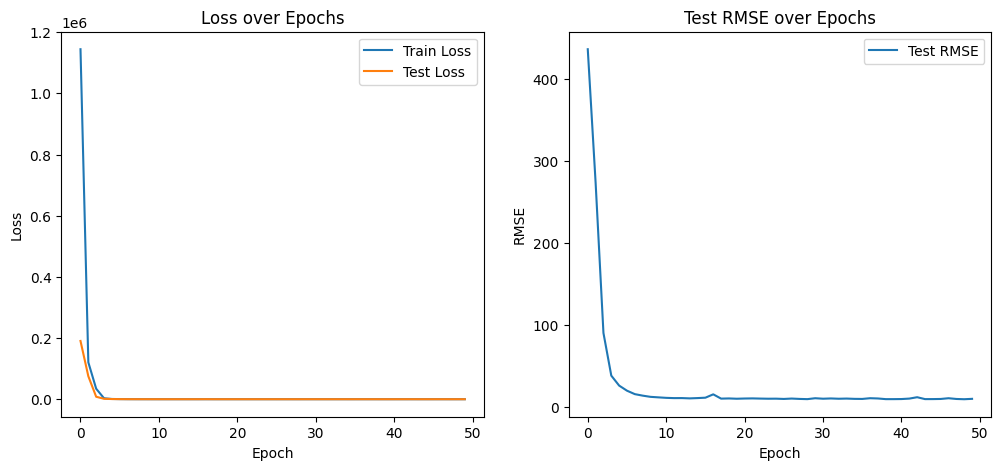

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_rmses, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Test RMSE over Epochs')
plt.legend()

plt.show()


## попытка номер 2


In [73]:
from sklearn.preprocessing import StandardScaler

target_scaler = StandardScaler()

y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

train_dataset = MusicDataset(X_train_scaled, y_train_scaled)
test_dataset = MusicDataset(X_test_scaled, y_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [72]:
class ImprovedNeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedNeuralNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

model = ImprovedNeuralNetwork(input_dim=X_train_scaled.shape[1]).to(device)

In [74]:
def test(model, criterion, test_loader):
    model.eval()
    test_loss = 0
    all_predictions = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch.view(-1, 1))
            test_loss += loss.item()
            all_predictions.append(predictions.cpu().numpy())

    test_loss /= len(test_loader)
    all_predictions = np.concatenate(all_predictions)

    all_predictions_rescaled = target_scaler.inverse_transform(all_predictions)
    y_test_rescaled = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, all_predictions_rescaled))

    return test_loss, rmse


In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

train_losses, test_losses, test_rmses = train(model, optimizer, criterion, train_loader, test_loader, epochs=10)


Epoch 1/10, Train Loss: 0.6831, Test Loss: 0.6788, Test RMSE: 8.8591
Epoch 2/10, Train Loss: 0.6300, Test Loss: 0.6672, Test RMSE: 8.8010
Epoch 3/10, Train Loss: 0.6145, Test Loss: 0.6649, Test RMSE: 8.7780
Epoch 4/10, Train Loss: 0.6031, Test Loss: 0.6672, Test RMSE: 8.8002
Epoch 5/10, Train Loss: 0.5947, Test Loss: 0.6645, Test RMSE: 8.8018
Epoch 6/10, Train Loss: 0.5844, Test Loss: 0.6713, Test RMSE: 8.8577
Epoch 7/10, Train Loss: 0.5765, Test Loss: 0.6608, Test RMSE: 8.7688
Epoch 8/10, Train Loss: 0.5679, Test Loss: 0.6670, Test RMSE: 8.8253
Epoch 9/10, Train Loss: 0.5612, Test Loss: 0.6748, Test RMSE: 8.8613
Epoch 10/10, Train Loss: 0.5525, Test Loss: 0.6686, Test RMSE: 8.8202


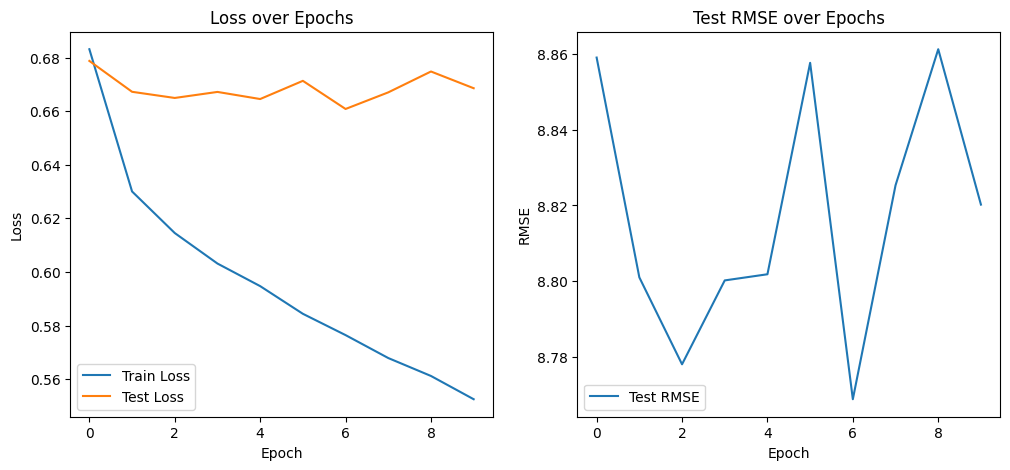

In [76]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_rmses, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Test RMSE over Epochs')
plt.legend()

plt.show()


## Попытка номер 3

In [27]:
from sklearn.preprocessing import StandardScaler

target_scaler = StandardScaler()

y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

train_dataset = MusicDataset(X_train_scaled, y_train_scaled)
test_dataset = MusicDataset(X_test_scaled, y_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)


In [39]:
class ImprovedNeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedNeuralNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

model = ImprovedNeuralNetwork(input_dim=X_train_scaled.shape[1]).to(device)

In [36]:
def test(model, criterion, test_loader):
    model.eval()
    test_loss = 0
    all_predictions = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch.view(-1, 1))
            test_loss += loss.item()
            all_predictions.append(predictions.cpu().numpy())

    test_loss /= len(test_loader)
    all_predictions = np.concatenate(all_predictions)

    all_predictions_rescaled = target_scaler.inverse_transform(all_predictions)
    y_test_rescaled = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, all_predictions_rescaled))

    return test_loss, rmse


In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

train_losses, test_losses, test_rmses = train(model, optimizer, criterion, train_loader, test_loader, epochs=10)


Epoch 1/10, Train Loss: 0.7131, Test Loss: 0.6829, Test RMSE: 8.9099
Epoch 2/10, Train Loss: 0.6528, Test Loss: 0.6714, Test RMSE: 8.8302
Epoch 3/10, Train Loss: 0.6363, Test Loss: 0.6625, Test RMSE: 8.7717
Epoch 4/10, Train Loss: 0.6269, Test Loss: 0.6636, Test RMSE: 8.7752
Epoch 5/10, Train Loss: 0.6186, Test Loss: 0.6581, Test RMSE: 8.7396
Epoch 6/10, Train Loss: 0.6123, Test Loss: 0.6585, Test RMSE: 8.7374
Epoch 7/10, Train Loss: 0.6058, Test Loss: 0.6612, Test RMSE: 8.7556
Epoch 8/10, Train Loss: 0.5998, Test Loss: 0.6581, Test RMSE: 8.7402
Epoch 9/10, Train Loss: 0.5937, Test Loss: 0.6592, Test RMSE: 8.7467
Epoch 10/10, Train Loss: 0.5882, Test Loss: 0.6570, Test RMSE: 8.7470


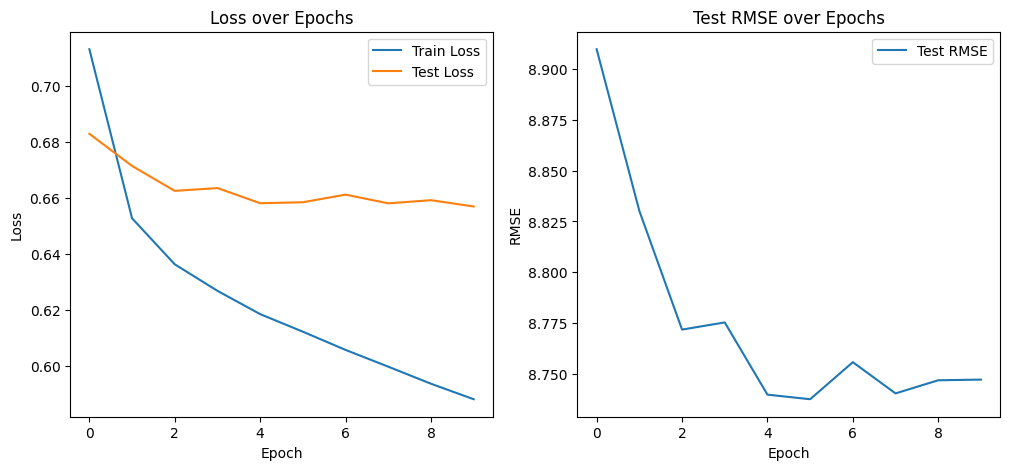

In [41]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_rmses, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Test RMSE over Epochs')
plt.legend()

plt.show()


In [42]:
def test(model, criterion, test_loader):
    model.eval()
    test_loss = 0
    all_predictions = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch.view(-1, 1))
            test_loss += loss.item()
            all_predictions.append(predictions.cpu().numpy())

    test_loss /= len(test_loader)
    all_predictions = np.concatenate(all_predictions)

    all_predictions_rescaled = target_scaler.inverse_transform(all_predictions)

    return all_predictions_rescaled


In [43]:
predictions = test(model, criterion, test_loader)

assert predictions.shape[0] == y_test.shape[0], f"Expected {y_test.shape[0]}, but got {predictions.shape[0]}"

print("Assert passed: количество предсказаний соответствует количеству тестовых объектов.")


Assert passed: количество предсказаний соответствует количеству тестовых объектов.


## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

В рамках данного задания была поставлена цель улучшить качество модели на задаче регрессии для предсказания года выпуска песни, используя нейронные сети на базе PyTorch. Основной метрикой оценки качества модели является RMSE (корень из среднеквадратичной ошибки). В ходе экспериментов была разработана нейронная сеть с различными архитектурами и гиперпараметрами, а также проведена нормализация целевой переменной.

Эксперимент 1: Базовая нейронная сеть
Архитектура:

Количество слоев: 3 полносвязных слоя.
Количество нейронов: 128 → 64 → 32 → 1.
Активация: ReLU на всех скрытых слоях.
Без регуляризации.
Гиперпараметры:

Оптимизатор: Adam.
Скорость обучения (learning rate): 0.001.
Batch size: 1024.
Weight Decay (L2-регуляризация): 1e-5.
Эпохи: 50.
Результаты:

RMSE на тестовой выборке: ~9.4.
Выводы: Базовая модель не достигла приемлемого качества. Наблюдалось переобучение после определенного количества эпох, что выражалось в снижении лосса на обучении, но стабильных высоких значениях лосса на тесте.

Эксперимент 2: Добавление нормализации таргета
Для второго эксперимента была проведена нормализация целевой переменной (y_train и y_test) с использованием StandardScaler. Цель нормализации — сделать целевую переменную сопоставимой по масштабу с входными признаками, что помогает улучшить производительность модели.

Архитектура:

Количество слоев: 4 полносвязных слоя (та же архитектура, что и в первом эксперименте).
Количество нейронов: 256 → 128 → 64 → 32 → 1.
Активация: ReLU на всех скрытых слоях.
Без регуляризации.
Гиперпараметры:

Оптимизатор: Adam.
Скорость обучения: 0.001.
Batch size: 1024.
Weight Decay: 1e-5.
Эпохи: 10.
Результаты:

RMSE на тестовой выборке: ~8.8.
Выводы: Нормализация таргета улучшила качество предсказаний, модель быстрее сходилась. Однако переобучение по-прежнему присутствовало, что указывало на необходимость регуляризации.

Эксперимент 3: Усложнение архитектуры и добавление Dropout
В третьем эксперименте была увеличена сложность модели и добавлен механизм Dropout для регуляризации, что помогло снизить переобучение.

Архитектура:

Количество слоев: 5 полносвязных слоев.
Количество нейронов: 512 → 256 → 128 → 64 → 32 → 1.
Активация: ReLU на всех скрытых слоях.
Dropout: 0.3 на всех скрытых слоях.
Гиперпараметры:

Оптимизатор: Adam.
Скорость обучения: 0.0005.
Batch size: 1024.
Weight Decay: 1e-5.
Эпохи: 50.
Результаты:

RMSE на тестовой выборке: ~8.74.
Выводы: Увеличение сложности модели и добавление Dropout позволили значительно снизить переобучение и улучшить метрику RMSE до ~8.74. Использование меньшего learning rate также помогло стабилизировать процесс обучения.


## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

## Вариант 1: Классификация каждого года как отдельного класса

In [56]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

label_encoder = LabelEncoder()
y_train_class = label_encoder.fit_transform(y_train).astype(np.int64)
y_test_class = label_encoder.transform(y_test).astype(np.int64)

train_dataset_class = MusicDataset(X_train_scaled, y_train_class)
test_dataset_class = MusicDataset(X_test_scaled, y_test_class)

train_loader_class = DataLoader(train_dataset_class, batch_size=1024, shuffle=True)
test_loader_class = DataLoader(test_dataset_class, batch_size=1024, shuffle=False)



In [57]:
class ClassificationNeuralNetwork(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationNeuralNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.network(x)

num_classes = len(np.unique(y_train_class))
model_class = ClassificationNeuralNetwork(input_dim=X_train_scaled.shape[1], num_classes=num_classes).to(device)

optimizer_class = torch.optim.Adam(model_class.parameters(), lr=0.001, weight_decay=1e-5)
criterion_class = nn.CrossEntropyLoss()


In [63]:
def test_classification(model, criterion, test_loader):
    model.eval()
    test_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device, dtype=torch.long)  # Преобразуем метки в Long
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            predicted_classes = torch.argmax(predictions, dim=1).cpu().numpy()
            all_predictions.extend(predicted_classes)
            all_labels.extend(y_batch.cpu().numpy())

    test_loss /= len(test_loader)

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=1)
    recall = recall_score(all_labels, all_predictions, average='macro')

    return test_loss, accuracy, precision, recall



In [64]:
def train_classification(model, optimizer, criterion, train_loader, test_loader, epochs=10):
    train_losses = []
    test_losses = []
    accuracies = []
    precisions = []
    recalls = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device, dtype=torch.long)  # Преобразуем метки в Long

            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        test_loss, accuracy, precision, recall = test_classification(model, criterion, test_loader)
        test_losses.append(test_loss)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
              f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    return train_losses, test_losses, accuracies, precisions, recalls



In [65]:
train_losses, test_losses, accuracies, precisions, recalls = train_classification(
    model_class, optimizer_class, criterion_class, train_loader_class, test_loader_class, epochs=10
)


Epoch 1/10, Train Loss: 3.0532, Test Loss: 3.0663, Accuracy: 0.0940, Precision: 0.4365, Recall: 0.0400
Epoch 2/10, Train Loss: 3.0423, Test Loss: 3.0595, Accuracy: 0.0977, Precision: 0.4381, Recall: 0.0420
Epoch 3/10, Train Loss: 3.0344, Test Loss: 3.0617, Accuracy: 0.0962, Precision: 0.4007, Recall: 0.0405
Epoch 4/10, Train Loss: 3.0276, Test Loss: 3.0568, Accuracy: 0.0937, Precision: 0.4004, Recall: 0.0402
Epoch 5/10, Train Loss: 3.0218, Test Loss: 3.0567, Accuracy: 0.0969, Precision: 0.3807, Recall: 0.0406
Epoch 6/10, Train Loss: 3.0167, Test Loss: 3.0558, Accuracy: 0.0975, Precision: 0.3970, Recall: 0.0422
Epoch 7/10, Train Loss: 3.0118, Test Loss: 3.0544, Accuracy: 0.0963, Precision: 0.3548, Recall: 0.0400
Epoch 8/10, Train Loss: 3.0077, Test Loss: 3.0529, Accuracy: 0.0945, Precision: 0.3424, Recall: 0.0429
Epoch 9/10, Train Loss: 3.0031, Test Loss: 3.0536, Accuracy: 0.0973, Precision: 0.3313, Recall: 0.0429
Epoch 10/10, Train Loss: 2.9997, Test Loss: 3.0550, Accuracy: 0.0972, Pre

## Вариант 2: Классификация по 10 бинам

In [66]:
num_bins = 10
y_train_bins = pd.cut(y_train, bins=num_bins, labels=False)
y_test_bins = pd.cut(y_test, bins=num_bins, labels=False)

train_dataset_bins = MusicDataset(X_train_scaled, y_train_bins)
test_dataset_bins = MusicDataset(X_test_scaled, y_test_bins)

train_loader_bins = DataLoader(train_dataset_bins, batch_size=1024, shuffle=True)
test_loader_bins = DataLoader(test_dataset_bins, batch_size=1024, shuffle=False)


In [67]:
model_bins = ClassificationNeuralNetwork(input_dim=X_train_scaled.shape[1], num_classes=num_bins).to(device)

optimizer_bins = torch.optim.Adam(model_bins.parameters(), lr=0.001, weight_decay=1e-5)
criterion_bins = nn.CrossEntropyLoss()


In [68]:
train_losses, test_losses, accuracies, precisions, recalls = train_classification(
    model_bins, optimizer_bins, criterion_bins, train_loader_bins, test_loader_bins, epochs=10
)


Epoch 1/10, Train Loss: 1.1321, Test Loss: 1.0578, Accuracy: 0.5811, Precision: 0.6532, Recall: 0.1877
Epoch 2/10, Train Loss: 1.0546, Test Loss: 1.0459, Accuracy: 0.5823, Precision: 0.6589, Recall: 0.2030
Epoch 3/10, Train Loss: 1.0369, Test Loss: 1.0391, Accuracy: 0.5832, Precision: 0.6679, Recall: 0.2033
Epoch 4/10, Train Loss: 1.0257, Test Loss: 1.0253, Accuracy: 0.5896, Precision: 0.6605, Recall: 0.2111
Epoch 5/10, Train Loss: 1.0169, Test Loss: 1.0250, Accuracy: 0.5905, Precision: 0.5654, Recall: 0.2146
Epoch 6/10, Train Loss: 1.0114, Test Loss: 1.0125, Accuracy: 0.5945, Precision: 0.4676, Recall: 0.2143
Epoch 7/10, Train Loss: 1.0052, Test Loss: 1.0211, Accuracy: 0.5909, Precision: 0.5524, Recall: 0.2161
Epoch 8/10, Train Loss: 1.0005, Test Loss: 1.0204, Accuracy: 0.5934, Precision: 0.5649, Recall: 0.2140
Epoch 9/10, Train Loss: 0.9962, Test Loss: 1.0117, Accuracy: 0.5931, Precision: 0.5566, Recall: 0.2188
Epoch 10/10, Train Loss: 0.9918, Test Loss: 1.0132, Accuracy: 0.5947, Pre

## проверка assert'ом

In [69]:
def test_classification(model, criterion, test_loader):
    model.eval()
    test_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device, dtype=torch.long)  # Преобразуем метки в Long
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            predicted_classes = torch.argmax(predictions, dim=1).cpu().numpy()
            all_predictions.extend(predicted_classes)
            all_labels.extend(y_batch.cpu().numpy())

    test_loss /= len(test_loader)

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=1)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=1)

    all_predictions = np.array(all_predictions)

    return all_predictions, test_loss, accuracy, precision, recall


In [70]:
# Получаем предсказания с помощью test функции для 1-го варианта
predictions, _, _, _, _ = test_classification(model_class, criterion_class, test_loader_class)

assert predictions.shape[0] == y_test_class.shape[0], f"Expected {y_test_class.shape[0]}, but got {predictions.shape[0]}"

print("Assert passed: количество предсказаний соответствует количеству тестовых объектов для 1-го варианта.")


Assert passed: количество предсказаний соответствует количеству тестовых объектов для 1-го варианта.


In [71]:
# Получаем предсказания с помощью test функции для 2-го варианта (10 бинов)
predictions, _, _, _, _ = test_classification(model_bins, criterion_bins, test_loader_bins)

assert predictions.shape[0] == y_test_bins.shape[0], f"Expected {y_test_bins.shape[0]}, but got {predictions.shape[0]}"

print("Assert passed: количество предсказаний соответствует количеству тестовых объектов для 2-го варианта.")


Assert passed: количество предсказаний соответствует количеству тестовых объектов для 2-го варианта.


## Анализ результатов
Выполнив два эксперимента по классификации, можно сделать следующие выводы:

Модель с каждым годом как отдельным классом:

Эта задача имеет слишком много классов (по количеству лет), что приводит к значительным трудностям в обучении. Модель с трудом различает все классы, особенно когда различия между годами не так сильно выражены.
Метрики accuracy, precision, recall ниже из-за сложности задачи.

Модель с 10 бинами:

Разбиение по 10 бинам значительно упрощает задачу классификации, поскольку уменьшается количество классов.
Модель показывает более высокие метрики, так как предсказать интервал лет проще, чем точный год.
Основное отличие между задачами классификации и регрессии заключается в целевой переменной. В регрессии предсказания — это непрерывные значения, и модель пытается минимизировать разницу между предсказанным и истинным значением. В классификации, напротив, модель предсказывает дискретные классы.